In [6]:
#Import Packages
import numpy as np               #version: 1.21.5
import sympy                     #version: 1.10.1
import galois
from sympy import poly, ntt, intt, Poly
from sympy.abc import x, y
import matplotlib.pyplot as plt  #version: 3.5.1
from merkle import MerkleTree, verify_decommitment  #The Merkle tree implementation is used from StarkWare Industries Ltd.

# 1 Definition of the Problem

## 1.1 CI Statement, Trace and Polynomial Constraints

In [7]:
#Number of elements in the trace. Has to be power of 2 in our example. You can try 2**3,2**4,2**5 etc, but need to adjust M below.
N = 2**2

#Define the trace A, for replicability set seed to 5
np.random.seed(5)
A = list(np.random.randint(low = 0,high=2,size=N))

assert len(A)==N, "length of A is different from N"     # Check that A has length specified in N
assert (N & (N - 1)) == 0, "N not a power of 2" # Make sure that N is a power of 2
print('A = ', A, ' | The trace (A) is --> ', np.isin(A, [0, 1]).all())

A =  [1, 0, 1, 1]  | The trace (A) is -->  True


## 1.2 Finite Field

In [8]:
M = 2**4+1                                              #Can alternatively choose 2**8+1, 2**16+1 etc
F = sympy.FiniteField(M)
def toInt(a):                                           #We define this function to be able to calculate integere values from the finite field expressions
    return int(sympy.FiniteField.to_sympy(0,a) % M)     #and to always get the positive integer realization and not the negative one.
assert sympy.isprime(M), f"M not a prime"               #Assert that M is a prime number
assert (M-1) % N == 0, f"N must be a divisor of (M-1)"    #N must be a divisor of (M-1) such that a subgroup exists
print('The Finite Field is:', F, '=', np.arange(0,M))

The Finite Field is: GF(17) = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [9]:
F_inv = [0] * (M - 1)
for i in range(1,M):
    F_inv[i-1] = toInt(F(i)**(M-2))
              
print('The multiplicative inverses of F(M) are: ', F_inv)

The multiplicative inverses of F(M) are:  [1, 9, 6, 13, 7, 3, 5, 15, 2, 12, 14, 10, 4, 11, 8, 16]


# 2 Arithmetization

## 2.1 Evaluating Trace as a Polynomial

In [10]:
# # Find generator g
# G = [0] * M
# print(range(1,M+1))
# g = 0
# for i in range(1,M+1):
#     G[0] = i
#     for k in range(2,M+1):
#         G[k-1] = G[k-2]*G[0] % M
#     if len(np.unique(G)) == N:
#         g = i
#         break       
# assert g!=0, "No generator g found"
# print('The G in M is -->', G)
# print('The generator g of the subgroup is -->', g)

# ## Define subgroup G
# G[0] = 1
# G[1] = g
# for i in range(2,M):
#     G[i-1] = G[i-2]*g % M
# G = np.unique(G)
# print('The subgroup G is -->', G)

# Find G in L domain with root of unity in galois field
FP = galois.GF(M)
g = FP.primitive_root_of_unity(N)
G = np.array([int(g**i) for i in range(N)])
print('The generator g of the subgroup is -->', g)
print('The subgroup G is -->', G)

The generator g of the subgroup is --> 13
The subgroup G is --> [ 1 13 16  4]


In [11]:
# #Lagrange Interpolation
# l1 = [0] * N
# f = poly(0,x,domain=F)
# for i in range(0,N):
#     l1[i] = 1
#     for j in range(0,N):
#         if j != i:
#             l1[i] = l1[i] * (x - G[j]) * F_inv[(G[i] - G[j] - 1) % M]
#     f = f + A[i] * l1[i]
# f = poly(f, domain = F)

# Inverse Number Theoretic Transform (INTT)
f = intt(A, prime=M)
f = Poly.from_list(f[::-1], x, domain = F)
print(' ')
print('The polynomial f associated to the trace ', A, ' is: ', f)

 
The polynomial f associated to the trace  [1, 0, 1, 1]  is:  Poly(x**3 - 4*x**2 - x + 5, x, modulus=17)


## 2.2 Evaluate the Polynomial on a Larger Domain

In [12]:
#Define domain L where polynomial is evaluated
L = np.array(range(1,M))

# #Calculate f(x) for x in L
# f_yy = [0] * len(L)
# for i in range(0,len(L)):
#     f_yy[i] = toInt(f(i+1))
# print('Calculate f(x) for L', f_yy)

#Calculate f(x) only for x in G to color dots red
# f_G = [0] * N
# for i in range(0,N):
#     f_G[i] = toInt(f(G[i])) 
# print('Calculate f(x) only for G', f_G)

f_coeffs = f.all_coeffs()[::-1]
f_coeffs_L = f_coeffs+[0 for i in range(M-len(f_coeffs)-1)] # coefficiant for domain L
#Calculate f(x) for x in L with NTT
f_yy = ntt(f_coeffs_L, prime=M)
print('Calculate f(x) for L', f_yy)

#Calculate f(x) only for x in G with NTT
f_G = ntt(f_coeffs, prime=M)
print('Calculate f(x) only for G', f_G)

Calculate f(x) for L [1, 10, 10, 0, 0, 8, 0, 8, 1, 13, 15, 9, 1, 6, 12, 3]
Calculate f(x) only for G [1, 0, 1, 1]


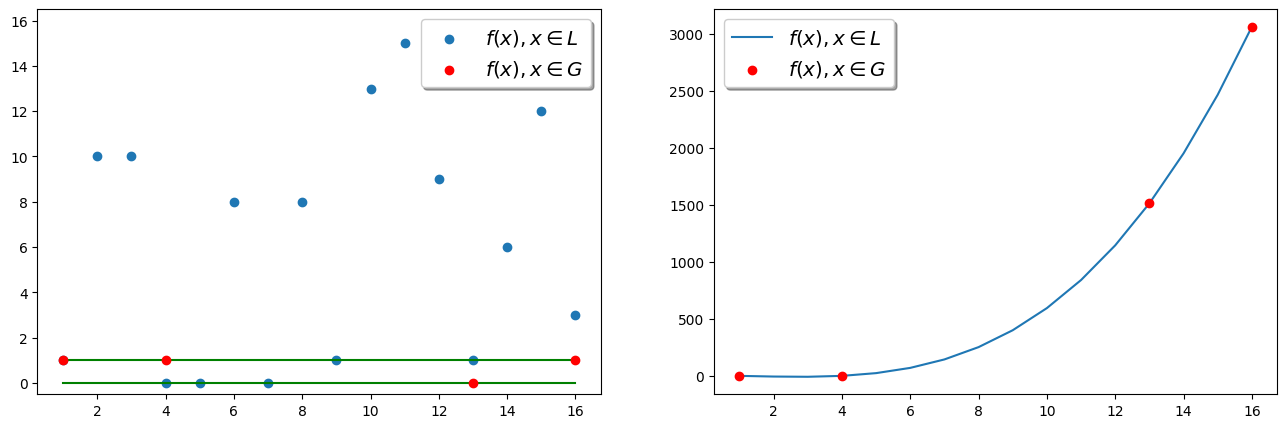

In [13]:
#Calculate f(x) in Euclidean space
coeffs = f.all_coeffs()[::-1]
yy = np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in L]) #caluclate f(x) for L
yy1 = np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in G]) #caluclate f(x) only for G

#Plot Graph
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
ax1.scatter(L, f_yy, zorder = 1, label = r'$f(x), x \in L$')
ax1.scatter(G,f_G, color = 'red', zorder = 2, label = r'$f(x), x \in G$')
ax1.plot(L,[0]*L, color = 'green', zorder = 1)
ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax1.set_ylim([-0.5, M-0.5])
ax1.legend(loc='best', shadow=True, fontsize='x-large')
ax2.plot(L, yy, zorder = 1, label = r'$f(x), x \in L$')
ax2.scatter(G,yy1, color = 'red', zorder = 2, label = r'$f(x), x \in G$')
ax2.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

## 2.3 Apply Constraints to Polynomial

We now combine the constraint defined above with the polynomial $f$ to get $c(x) = f(x)^2 -f(x)$

In [14]:
constraint = poly(y**2 - y)      # The only elements that are roots of these constraints are 0 and 1.
print(constraint)

Poly(y**2 - y, y, domain='ZZ')


In [15]:
#Get constraint polynomial
c = sympy.compose(constraint,f)
c = poly(c,x,domain = F)
print('We have c(x) = ', c)

We have c(x) =  Poly(x**6 - 8*x**5 - 3*x**4 - x**2 + 8*x + 3, x, modulus=17)


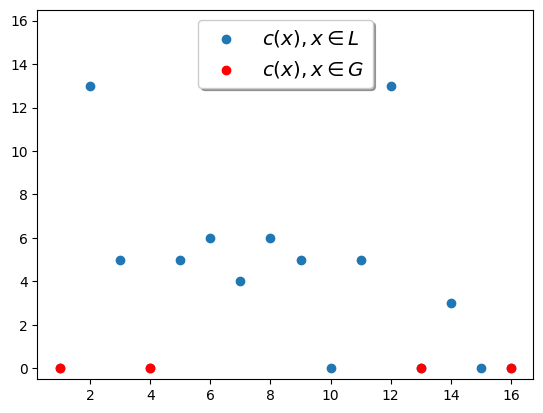

In [16]:
#Calculate c(x) for x in L
c_yy = [0] * len(L)
for i in range(0,len(L)):
    c_yy[i] = toInt(c(i+1))

##Calculate c(x) only for x in G
c_G = [0] * N
for i in range(0,N):
    c_G[i] = toInt(c(G[i]))

##Plot graph
plt.scatter(L, c_yy, zorder = 1, label = r'$c(x), x \in L$')
plt.scatter(G,c_G, color = 'red', zorder = 2, label = r'$c(x), x \in G$')
plt.ylim([-0.5, M-0.5])
plt.legend(loc=9, shadow=True, fontsize='x-large')
plt.show()

## 2.4 Create the Composition Polynomial

We now define the Composition Polynomial, i.e.  $p(x) = \dfrac{c(x)}{x^N-1}$

In [17]:
#First calcualte the denominator
u = poly(x**N - 1, domain = F)  

#Calculate the composition polynomial
pRaw = sympy.div(c, u, domain = F)
p = pRaw[0]
pRemainder = pRaw[1]
print('Composition polynomial: ', p, ' , The remainder is: ', pRemainder);

Composition polynomial:  Poly(x**2 - 8*x - 3, x, modulus=17)  , The remainder is:  Poly(0, x, modulus=17)


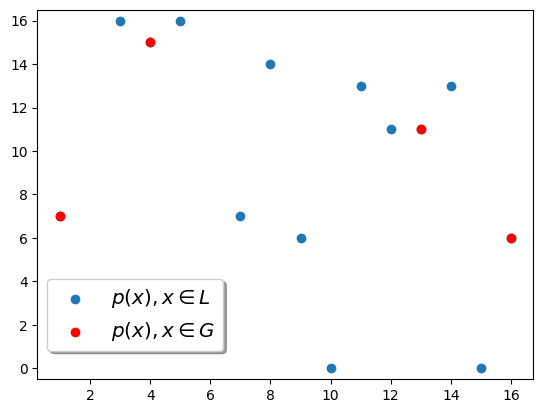

In [18]:
#Calculate p(x) for x in L
p_yy = [0] * len(L)
for i in range(0,len(L)):
    p_yy[i] = toInt(p(i+1))

##Calculate p(x) only for x in G
p_G = [0] * N
for i in range(0,N):
    p_G[i] = toInt(p(G[i]))

##Plot graph
plt.scatter(L, p_yy, zorder = 1, label = r'$p(x), x \in L$')
plt.scatter(G,p_G, color = 'red', zorder = 2, label = r'$p(x), x \in G$')
plt.ylim([-0.5, M-0.5])
plt.legend(loc='lower left', bbox_to_anchor=(0, 0.05), shadow=True, fontsize='x-large')
plt.show()

## 2.5 Commitments

The prover now commits to $f(x)$ and $p(x)$ in Merkle trees. We use the Merkle tree script from Starkware.

In [19]:
#Build Merkle tree
MT_f = MerkleTree(f_yy) # merkle of calculated f(x) for L
MT_p = MerkleTree(p_yy) # merkle of calculated p(x) for L

#Get Merkle roots
root_f = MT_f.root
root_p = MT_p.root

print('Prover sends Merkle root of MT_f to verifier: ')
print(root_f)
print('The leaves of MT_f are: ', MT_f.data); print(' ')
print('Prover sends Merkle root of MT_p to verifier: ')
print(root_p)
print('The leaves of MT_p are: ', MT_p.data)

Prover sends Merkle root of MT_f to verifier: 
b212585e136aea0d6cc952c28aa8a6228c19a686f41ded25b9d70556b6c6aae0
The leaves of MT_f are:  [1, 10, 10, 0, 0, 8, 0, 8, 1, 13, 15, 9, 1, 6, 12, 3]
 
Prover sends Merkle root of MT_p to verifier: 
8cfb8ce05383018cb1411583f34dec5ba7531e34941c2315db01c9cf89138659
The leaves of MT_p are:  [7, 2, 16, 15, 16, 2, 7, 14, 6, 0, 13, 11, 11, 13, 0, 6]


## 2.6. Querying

Motivation of why we want to query the equation $p(x)u(x) = c(x)$.

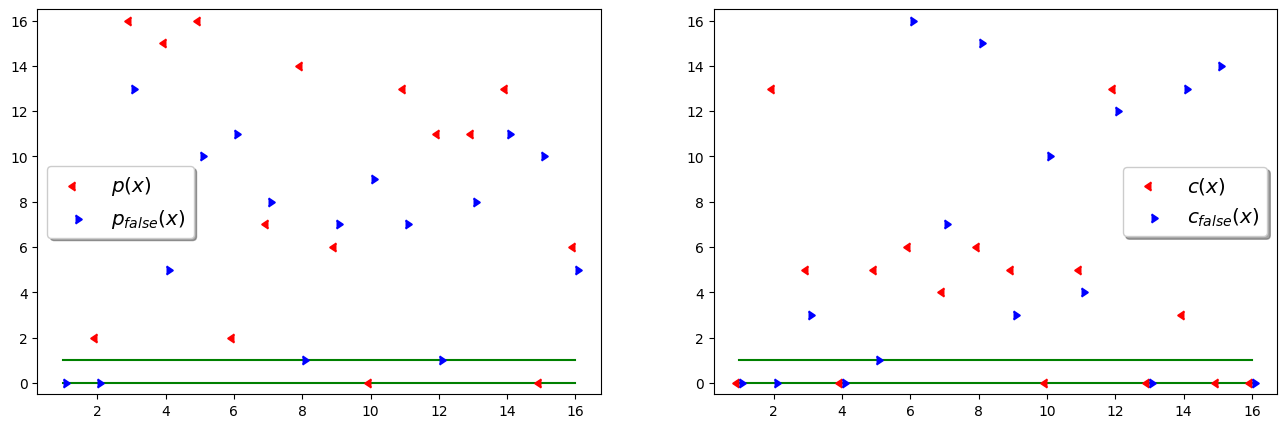

In [20]:
#Define p_false
p_false = poly(15*x**2+6*x+13, domain = F)
c_false = p_false*u

#Calculate y values
p_false_yy = [0] * len(L)
c_false_yy = [0] * len(L)
for i in range(0,len(L)):
    p_false_yy[i] = toInt(p_false(i+1))
    c_false_yy[i] = toInt(c_false(i+1))

#Plot Graph
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
ax1.scatter(L, p_yy, marker = 8, color = 'red', zorder = 2, label = '$p(x)$')
ax1.scatter(L, p_false_yy, marker = 9 ,color = 'blue', zorder = 2, label = '$p_{false}(x)$')
ax1.plot(L,[0]*L, color = 'green', zorder = 1)
ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax1.set_ylim([-0.5, M-0.5])
ax1.legend(loc='center left', shadow=True, fontsize='x-large')
ax2.scatter(L, c_yy, marker = 8, color = 'red', zorder = 2, label = '$c(x)$')
ax2.scatter(L, c_false_yy, marker = 9 ,color = 'blue', zorder = 2, label = '$c_{false}(x)$')
ax2.plot(L,[0]*L, color = 'green', zorder = 1)
ax2.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax2.set_ylim([-0.5, M-0.5])
ax2.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

### Querying Protocol

The verifier queries the prover for values $\{z\in L | z\notin G \}$.\
The prover returns $f(z)$, $p(z)$ and the Merkle paths corresponding to $z$.\
The verifier checks whether (i) the received values fit the commitment and (ii) the equation
$p(z) = \dfrac{f(z)^2-f(z)}{z^N-1}$

In [21]:
#Choose number of queries q
q = 2

#Get random numbers, set seed to 70 for replicabiltiy
assert q <= len(L)-N, "You query more often than possible, reduce q"
np.random.seed(70)
z = list(np.random.choice(np.delete(L,G-1,0), q, replace=False)) #Exclude G values from possible queries

print('The selected random numbers are: ', z); print(' ')

The selected random numbers are:  [3, 14]
 


In [22]:
#Querying rounds
for i in range(0,len(z)):
    print('-----------------')
    print('Query ', i+1,': ')
    print('Verifier queries: z=',z[i]); print(' ')
    
    #Prover sends information
    proof_f = toInt(f(z[i]))
    proof_p = toInt(p(z[i]))
    print(f'Prover sends: f({z[i]}) = {proof_f} and p({z[i]}) = {proof_p},')
    print('the correpsonding Merkle Paths for f(z):')
    leafID = np.where(L==z[i])[0][0] #index of z[i] in L
    path_f = MT_f.get_authentication_path(leafID)
    print(path_f)
    print('and for p(z):')
    path_p = MT_p.get_authentication_path(leafID)
    print(path_p)
    print(' ')

    #Calculate equation 
    print('(i): Verifier now checks equation: p(z)(z^N-1) = f(z)^2-f(z)')
    LHS = (proof_p*(toInt(z[i])**N-1)) % M
    RHS = ((proof_f**2) - proof_f) % M
    print('LHS yields: ', LHS, '; RHS yields: ', RHS)
    if LHS==RHS:
        print(f'Equation correct, proof continues')
    else:
        print(f'PROOF FAILS: Equation not correct.'); break
    print(' ')
    
    #Check if Merkle root fits the one received before
    print('(ii): Verifier now checks whether received p(z) and f(z) correspond to Merkle root received upfront')
    if verify_decommitment(leafID, proof_f, path_f, root_f): #check for f
        print('f(z) corresponds to commitment, proof can continue')
    else:
        print('PROOF FAILS: f(z) DOES NOT corresponds to commitment!'); break
    if verify_decommitment(leafID, proof_p, path_p, root_p): #check for p
        print('p(z) corresponds to commitment, proof can continue')
    else:
        print('PROOF FAILS: p(z) DOES NOT corresponds to commitment!'); break

-----------------
Query  1 : 
Verifier queries: z= 3
 
Prover sends: f(3) = 10 and p(3) = 16,
the correpsonding Merkle Paths for f(z):
['f9c901cd6ec91ac1e9189fa681fe6e5266f37854449aab61f514371bf98bffbd', 'f375975f10e5cf8d08d3f8624e6440bdd8b1bc01d4bffb6da61f784914ec20da', '64711ec8699b9eebb8203253fdc41f016b806768baa087f98e2a8a11edf39ffd', '5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9']
and for p(z):
['9cd7ba58726349f8f68a78f5b9d162cece7c64ade8998e2226f4b02904fbf601', 'cd7c27e0562023f47c00a760175f93c1bbbe8e980045b3a1ca468d0319f5cbb1', '1afb6b2b218b5e02b7cbe02e89d4e26ebc322e045ada4a719d3cc1416b82736b', 'e629fa6598d732768f7c726b4b621285f9c3b85303900aa912017db7617d8bdb']
 
(i): Verifier now checks equation: p(z)(z^N-1) = f(z)^2-f(z)
LHS yields:  5 ; RHS yields:  5
Equation correct, proof continues
 
(ii): Verifier now checks whether received p(z) and f(z) correspond to Merkle root received upfront
f(z) corresponds to commitment, proof can continue
p(z) corresponds to com

# 3 Low-Degree Testing

The objective of the low-degree testing is that the verifier can learn whether the composition polynomial is of low degree by just a few querying steps.

## 3.1 Motivation

Here we calcluate another polynomial $f^{H}$ of high degree that fits $f$ in all points $x \in L$ except for one $x$ where $x\notin G$. (Specifically we set $f^H(16)=4$)\
This shows that it is possible with a high degree polynomial to be sufficiently close to a low degree polynomial such that the tests that we did so far are not sufficient to trust the prover. 

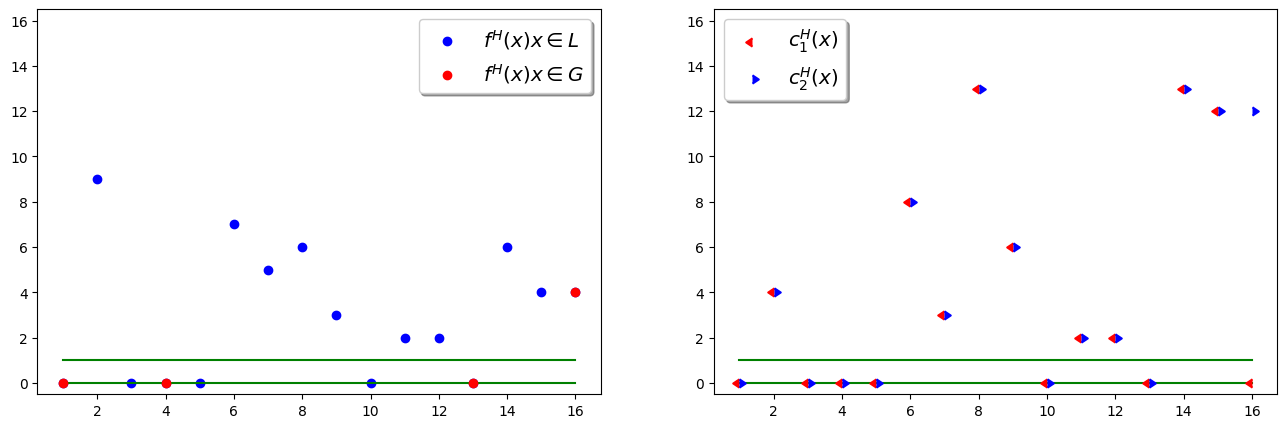

In [23]:
#Define polys
f_H = poly(x**15 + 4*x**14 + 6*x**13 +  11*x**12 + 6*x**11 + 5*x**10 + 6*x**9 + 13*x**8 + 7*x**7 + 7*x**6 + 12*x**5 + 8*x**4 + 2*x**3 + 2*x**2 + 9*x + 3, x, modulus=17)
p_H  = poly(13*x**15 + 8*x**14 + 11*x**13 + 2*x**12 + 16*x**11 + 9*x**10 + 3*x**9 + 11*x**8 + 6*x**7 + 14*x**6 + 13*x**5 + 4*x**4 + 8*x**3 + 3*x**2 + 2*x + 14, x, modulus=17)

#Define vector for u
u_vec = [0]*L
for i in range(len(L)):
    u_vec[i] = ((i+1)**4-1)%M
u_vec[i] = np.array(u_vec[i])

#Calculate y points of polys
f_H_yy = [0] * len(L)
p_H_yy = [0] * len(L)
for i in range(0,len(L)):
    f_H_yy[i] = toInt(f_H(i+1))
    p_H_yy[i] = toInt(p_H(i+1))

#Calculate c1 and c2
c1_H_yy = [0]*len(L)
c2_H_yy = [0]*len(L)
for k in range(len(L)):
    c1_H_yy[k] = (p_H_yy[k]*u_vec[k])%M         
    c2_H_yy[k] = ((f_H_yy[k])**2-f_H_yy[k])%M  

##Calculate f(x) only for x in G
f_H_G = [0] * N
for i in range(0,N):
    f_H_G[i] = toInt(f_H(G[i]))

#Plot Graph
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 5)
ax1.scatter(L, f_H_yy, color = 'blue', zorder = 1, label = '$f^H(x) x \in L$')
ax1.scatter(G, f_H_G, color = 'red', zorder = 2, label = '$f^H(x) x \in G$')
ax1.plot(L,[0]*L, color = 'green', zorder = 1)
ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax1.set_ylim([-0.5, M-0.5])
ax1.legend(loc='best', shadow=True, fontsize='x-large')
ax2.scatter(L, c1_H_yy, marker = 8, color = 'red', zorder = 2, label = '$c_1^H(x)$')
ax2.scatter(L, c2_H_yy, marker = 9 ,color = 'blue', zorder = 2, label = '$c_2^H(x)$')
ax2.plot(L,[0]*L, color = 'green', zorder = 1)
ax2.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax2.set_ylim([-0.5, M-0.5])
ax2.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

## 3.2 Setup

We now define $\bar{d}$, i.e. the highest possible degree for the composition polynomial.  \
In our example this is defined by: $\bar{d} = 2(N-1)-N = N-2$.

In [24]:
d_bar = N - 2
print('The highest possible degree of the composition polynomial is:', d_bar)

The highest possible degree of the composition polynomial is: 2


## 3.3 Commitment Round

In the commitment round, the prover executes the FRI protocol.\
We know that after applying the FRI operator exactly $\lambda = \log_2(\bar{d})+1$ times, the polynomial is reduced to a constant. \
In each round, the verifier sends a random $\alpha\in F$ which the prover needs.  \
The prover commits in each round to the current state and at the end sends the remaining constant to the verifier.

In [25]:
#Calculate number of iterations in the FRI protocol
Lambda = int(np.log2(d_bar) + 1)
print('The FRI protocol will take', Lambda, 'iterations.')

The FRI protocol will take 2 iterations.


In [26]:
#Set a vector to store p_k, ie the polynomials
P = [0]*(Lambda+1) 
P[0] = p
print(P)

[Poly(x**2 - 8*x - 3, x, modulus=17), 0, 0]


In [27]:
#Set alpha, for replicability set seed to 260  
np.random.seed(260)
alpha = list(np.random.randint(low = 0,high=M,size=Lambda)) #do it random
assert len(alpha) == Lambda, "Not enough elements for alpha"
print('Alphas sent to the prover are: ',alpha)

#Set up vectors to store Merkle tree commitments
merkleTrees = [0]*(Lambda-1)
merkleRoots = [0]*(Lambda-1)

#Define function to get domain
def getDomain(L,k):
    assert (len(L) & (len(L) - 1)) == 0, "Size of L is not a power of 2" #assert size of L is a power of 2
    for _ in range(k+1):
        L = np.unique(L**2%M)
    return L

Alphas sent to the prover are:  [10, 15]


In [28]:
#Apply the FRI operator Lambda times
for k in range(0,Lambda):
    #Prover splits p_k into even and odd parts
    g = sympy.Poly.from_list(P[k].all_coeffs()[::-1][::2][::-1], x, domain = F)       # Prover separates into even part
    h = sympy.Poly.from_list(P[k].all_coeffs()[::-1][1::2][::-1], x, domain = F)      # Prover separates into odd part
    print('g', k, '=',g)
    print('h', k, '=',h)
    #Calculate next p_k polynomial
    P[k+1] = g + poly(alpha[k],x,domain=F) * h # g + alpha * h
    print('P[next]', P[k+1])
    if k == Lambda-1: # last round
        constant = int(P[k+1](0))
        print('------------')
        print('Round ', k+1, ' of ', Lambda)
        print('A constant remains: ',toInt(constant))
    else:
        #####Commit this polynomial over L^2, L^4 etc...
        #First get domain
        Lcur = getDomain(L,k)
        
        #Calculate p_k(x) values in this domain for leaves of the Merkle tree
        leaves = [0] * len(Lcur)
        for i in range(0,len(Lcur)):
            leaves[i] = toInt(P[k+1](Lcur[i]))
        merkleTrees[k] = MerkleTree(leaves)
        merkleRoots[k] = merkleTrees[k].root
        print('------------')
        print('Round ', k+1, ' of ', Lambda)
        print('The new polynomial is:', P[k+1])
        print('The polynomial is evaluated in:' , Lcur) #inputs
        print('The leaves of the Merkle tree are: ', leaves) #result
            
#Send constant
print(' ')
print('The prover now sends the constant:', toInt(constant))
print('and the Merkle roots to the verifier:')
print(merkleRoots)

g 0 = Poly(x - 3, x, modulus=17)
h 0 = Poly(-8, x, modulus=17)
P[next] Poly(x + 2, x, modulus=17)
------------
Round  1  of  2
The new polynomial is: Poly(x + 2, x, modulus=17)
The polynomial is evaluated in: [ 1  2  4  8  9 13 15 16]
The leaves of the Merkle tree are:  [3, 4, 6, 10, 11, 15, 0, 1]
g 1 = Poly(2, x, modulus=17)
h 1 = Poly(1, x, modulus=17)
P[next] Poly(0, x, modulus=17)
------------
Round  2  of  2
A constant remains:  0
 
The prover now sends the constant: 0
and the Merkle roots to the verifier:
['7881ac8565912f59108e1d3a7e01f60b8a4381bc78745af05b4582bfb731484f']


## 3.4 Querying Round

In [29]:
#Define the z that the verifier queries for, for replicability set seed to 2
np.random.seed(2) 
z = np.random.choice(np.delete(L,G-1,0), 1, replace=False)[0] #Exclude G values from possible queries
print('The verifier queries for z =',z)

The verifier queries for z = 12


In [30]:
for k in range(0,Lambda):
    print(' ')
    print('Round ', k+1, ' of ', Lambda)
    print('----------------')
    
    #verifier queries for p(z^2^k) and p(-z^2^k)
    pP = toInt(P[k](toInt(F(z)**(2**k))))
    pN = toInt(P[k](toInt(F(-1)*F(z)**(2**k))))
    print(f'The prover returns p({z}^{2**k})={pP} and p(-{z}^{2**k})={pN}')
    
    #Verifier solves system of equations to get g(z^2^k) and h(z^2^k)
    h_ver = toInt(F((pP-pN)*F_inv[toInt(F(2)*F(z)**(2**k))-1]))
    g_ver = toInt(F(pN) + F(z)**(2**k)*F(h_ver))
    print(f'The verifier finds g(z^{2**(k+1)})={g_ver} and h(z^{2**(k+1)})={h_ver}')

    #Compute next p_{k+1}(z)
    pZ_ver = toInt(F(g_ver) + F(alpha[k])*F(h_ver))
    print(f'and then calculates p_{k+1} = g(z^{2**(k+1)}) + alpha_{k+1} * h(z^{2**(k+1)})', 
          f'= {g_ver}+{alpha[k]}*{h_ver} = {pZ_ver}')
    #Check commitment, do not need to check commitment in last round, just compare constants in last round
    if k<Lambda-1: 
        print(' ')
        print(f'Verifier checks whether calculated p_{k+1}={pZ_ver} correspond to commitment in Merkle tree')
        leafID = np.where(getDomain(L,k)==toInt(F(z)**(2**(k+1))))[0][0] 
        path = merkleTrees[k].get_authentication_path(leafID)
        print(f'Prover sends authentification path for leaf number {leafID}, where z={toInt(F(z)**(2**(k+1)))}',
              f'and p_{k+1}({toInt(F(z)**(2**(k+1)))})={toInt(P[k+1](toInt(F(z)**(2**(k+1)))))} this is:')
        print(' '); print(path)
        print('and uses this to calculate the Merkle Root'); print(' ')
        
        if verify_decommitment(leafID, pZ_ver, path, merkleRoots[k]): 
            print(f'p_{k+1}={pZ_ver} corresponds to commitment, proof can continue.')
        else:
            print(f'PROOF FAILS, p_{k+1}={toInt(pZ_ver)} DOES NOT correspond to commitment!')
    else:
        print(f'Verifier finds constant {toInt(pZ_ver)} which equals {toInt(constant)} received from prover')
        print('PROOF SUCCESSFUL!')

 
Round  1  of  2
----------------
The prover returns p(12^1)=11 and p(-12^1)=16
The verifier finds g(z^2)=5 and h(z^2)=9
and then calculates p_1 = g(z^2) + alpha_1 * h(z^2) = 5+10*9 = 10
 
Verifier checks whether calculated p_1=10 correspond to commitment in Merkle tree
Prover sends authentification path for leaf number 3, where z=8 and p_1(8)=10 this is:
 
['aa5dfb1acf8e760c89dfac0046887063453a25574f7d8f8b923adf5c82ec4acd', '13656c83d841ea7de6ebf3a89e0038fea9526bd7f686f06f7a692343a8a32dca', 'e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683']
and uses this to calculate the Merkle Root
 
p_1=10 corresponds to commitment, proof can continue.
 
Round  2  of  2
----------------
The prover returns p(12^2)=10 and p(-12^2)=11
The verifier finds g(z^4)=2 and h(z^4)=1
and then calculates p_2 = g(z^4) + alpha_2 * h(z^4) = 2+15*1 = 0
Verifier finds constant 0 which equals 0 received from prover
PROOF SUCCESSFUL!


# 4 Attack With False Trace

This part only works for the values in the numerical example, ie $M=17$ and $N=4$.

The polynomial f_false asociated to the trace  [2 0 1 1]  is:  Poly(-3*x**3 - 8*x**2 - 5*x + 1, x, modulus=17)
c polynomial:  Poly(-8*x**6 - 3*x**5 - 8*x**4 - 8*x**3 - 5*x, x, modulus=17)
Composition polynomial:  Poly(-8*x**2 - 3*x - 8, x, modulus=17)  , The remainder is:  Poly(-8*x**3 - 8*x**2 - 8*x - 8, x, modulus=17)
c_bar polynomial:  Poly(-8*x**6 - 3*x**5 - 8*x**4 + 8*x**2 + 3*x + 8, x, modulus=17)


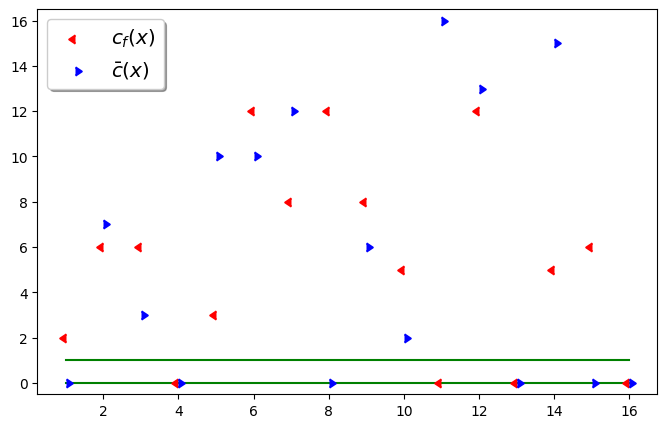

In [31]:
if M==17 and N==4:
    #Define the trace that the poly f_false needs to fit
    A_false = np.array([2,0,1,1])

    #Interpolate values
    l1 = [0] * N
    f_false = poly(0,x,domain=F)
    for i in range(0,N):
        l1[i] = 1
        for j in range(0,N):
            if j != i:
                l1[i] = l1[i] * (x - G[j]) * F_inv[(G[i] - G[j] - 1) % M]
        f_false = f_false + A_false[i] * l1[i]  
    f_false = poly(f_false, domain = F)
    print('The polynomial f_false asociated to the trace ', A_false, ' is: ', f_false)

    #Calculate c
    c_false = sympy.compose(constraint,f_false)
    c_false = poly(c_false,x,domain = F)
    print('c polynomial: ', c_false)

    #Calculate composition polynomial
    pRaw_false = sympy.div(c_false, u, domain = F)
    p_false = pRaw_false[0]; pRemainder_false = pRaw_false[1]
    print('Composition polynomial: ', p_false, ' , The remainder is: ', pRemainder_false)

    #Calculate c_bar(x)
    c_bar = p_false*u
    print('c_bar polynomial: ', c_bar)

    #Calculate c_f(x) and c_bar(x) for x in L
    c_bar_yy = [0] * len(L)
    c_false_yy = [0] * len(L)
    for i in range(0,len(L)):
        c_bar_yy[i] = toInt(c_bar(i+1))
        c_false_yy[i] = toInt(c_false(i+1))

    #Plot Graph
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)
    ax1.scatter(L, c_false_yy, marker = 8, color = 'red', zorder = 2, label = '$c_f(x)$')
    ax1.scatter(L, c_bar_yy, marker = 9 ,color = 'blue', zorder = 2, label = r'$\bar{c}(x)$')
    ax1.plot(L,[0]*L, color = 'green', zorder = 1)
    ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
    ax1.set_ylim([-0.5, M-0.5])
    ax1.legend(loc='best', shadow=True, fontsize='x-large')
    plt.show()